In [1]:
query = """
SELECT [GameID]
      ,[PlayID]
      ,o.TeamCodeID as offenseID
      ,o.TeamName as OffenseTeamName
      ,d.TeamCodeID as defenceID
      ,d.TeamName as DefenseTeamName
      ,fz.FieldZone as FieldZone
      ,[PlayTypeID]
      ,w.ConditionType as ConditionType
      ,ws.WindSpeedCategory as WindSpeedCategory
      ,[StadiumID]
      ,surf.[SurfaceID]
      ,[SurfaceType]
      ,[GameDate]
      ,YEAR(GameDate) as GameYear
      ,[SuccessfulPlay]
      ,[Shotgun]
      ,[AtHome]
      ,[QBisRookie]
      ,[Down]
      ,[YardsToGo]
      ,CASE
            WHEN yardsToGo < 11 THEN CAST(yardsToGo as varchar(5))
            WHEN yardsToGo < 15 THEN '11-15'
            WHEN yardsToGo < 20 THEN '15-20'
            WHEN yardsToGo < 30 THEN '20-30'
            ELSE '30+'
       END as yardsToGoBucket
      ,[NumberOfPlays]
      ,[TimeoutsLeft]
      ,[SecondsLeftInQuarter]
      ,[SecondsLeftInQuarterBucketID]
      ,qsb.bucket as SecondsInQuarterBucket
      ,[SecondsLeftInQuarter]/60 as [MinutesLeftInQuarter]
      ,[SecondsLeftInHalf]
      ,[SecondsLeftInHalfBucketID]
      ,hsb.bucket as SecondsInHalfBucket
      ,[SecondsLeftInGame]
      ,[SecondsLeftInGameBucketID]
      ,gsb.Bucket as SecondsInGameBucket
      ,[GameQuarter]
      ,[CurrentPointsOnOffense]
      ,[OffensePointsBucketID]
      ,opb.Bucket as OffensePointsBucket
      ,[CurrentPointsOnDefense]
      ,[DefensePointsBucketID]
      ,dpb.Bucket as DefensePointsBucket
      ,[PointsDifference]
      ,[PointsDifferenceBucketID]
      ,pdb.Bucket as PointsDifferenceBucket
      ,[OffenseWinLossRatio]
      ,[DefenseWinLossRatio]
      ,[SeasonWeek]
  FROM [NFL_Prediction].[nfl].[f_play] p
  INNER JOIN [NFL_Prediction].[nfl].[d_field_zone] fz on p.FieldZoneID = fz.FieldZoneID
  INNER JOIN [NFL_Prediction].[nfl].[d_team] o on p.OffenseID = o.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_team] d on p.DefenceID = d.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_weather] w on p.WeatherID = w.WeatherID
  INNER JOIN [NFL_Prediction].[nfl].[d_wind_speed] ws on p.SpeedID = ws.WindSpeedID
  INNER JOIN [NFL_Prediction].[nfl].[d_surface] surf on p.SurfaceID = surf.SurfaceID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] qsb on p.SecondsLeftInQuarterBucketID = qsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] hsb on p.SecondsLeftInHalfBucketID = hsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] gsb on p.SecondsLeftInGameBucketID = gsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] opb on p.OffensePointsBucketID = opb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] dpb on p.DefensePointsBucketID = dpb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] pdb on p.PointsDifferenceBucketID = pdb.PointsBucketID
  where MainPlayerID is not null
"""

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [3]:
import pyodbc
sql_conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost\\uni;DATABASE=NFL_Prediction;Trusted_Connection=yes')
df = pd.read_sql(query, sql_conn)

## Prediction Column Analysis
Analyse out the prediction column, PlayTypeID (1=PASS, 2=RUSH)

In [40]:
df['PlayTypeID'].count()

639914

In [41]:
df['PlayTypeID'].value_counts()

1    364072
2    275842
Name: PlayTypeID, dtype: int64

In [42]:
df['PlayTypeID'].describe()

count    639914.000000
mean          1.431061
std           0.495225
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: PlayTypeID, dtype: float64

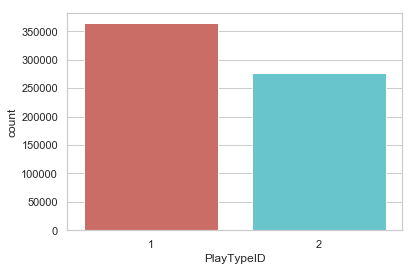

<Figure size 432x288 with 0 Axes>

In [43]:
sns.countplot(x='PlayTypeID', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [44]:
rush_count = len(df[df['PlayTypeID'] == 2])
pass_count = len(df[df['PlayTypeID'] == 1])
pass_percentage = pass_count/(pass_count+rush_count)
rush_percentage = rush_count/(pass_count+rush_count)
print(f'percentage of rush plays are {rush_percentage*100}')
print(f'percentage of pass plays are {pass_percentage*100}')

percentage of rush plays are 43.10610488284363
percentage of pass plays are 56.89389511715637


The predictive classes are not too imblanaced so we should not require any balancing of the prediction

In [30]:
df.groupby('PlayTypeID').mean()

,GameID,PlayID,TeamCodeID,TeamCodeID,FieldZoneID,MainPlayerID,WeatherID,SpeedID,StadiumID,SurfaceID,...,SecondsLeftInQuarter,SecondsLeftInHalf,SecondsLeftInGame,GameQuarter,CurrentPointsOnOffense,CurrentPointsOnDefense,PointsDifference,OffenseWinLossRatio,DefenseWinLossRatio,SeasonWeek
PlayTypeID,,,,,,,,,,,,,,,,,,,,,
1,2568.993065,419359.769930,16.458711,16.480265,2.857091,5261.071986,14.752637,2.045631,44.110019,10.711840,...,420.213842,810.321294,1698.816426,2.585607,9.393263,12.377535,-2.984272,0.0,0.0,9.489318
2,2500.274654,408081.606605,16.503411,16.418946,2.923830,5614.931203,14.770224,2.078697,44.080716,10.727228,...,450.830225,884.914592,1768.757517,2.543017,10.842055,9.888650,0.953404,0.0,0.0,9.573738


In [75]:
df[['PlayTypeID','SecondsLeftInQuarter','SecondsLeftInHalf','SecondsLeftInGame','CurrentPointsOnOffense','CurrentPointsOnDefense','PointsDifference']].groupby('PlayTypeID').mean()

,SecondsLeftInQuarter,SecondsLeftInHalf,SecondsLeftInGame,CurrentPointsOnOffense,CurrentPointsOnDefense,PointsDifference
PlayTypeID,,,,,,
1,420.213842,810.321294,1698.816426,9.393263,12.377535,-2.984272
2,450.830225,884.914592,1768.757517,10.842055,9.888650,0.953404


## Key Visualisations
Lets analyse the rest of the data through some key visualisations

### FieldZoneId

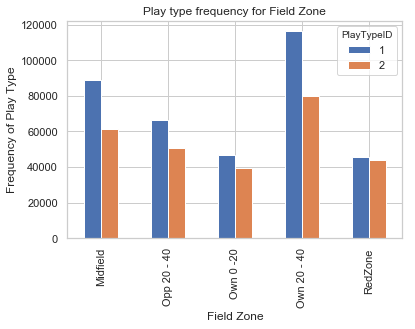

In [45]:
%matplotlib inline
pd.crosstab(df.FieldZone, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for Field Zone')
plt.xlabel('Field Zone')
plt.ylabel('Frequency of Play Type')
plt.savefig('fieldzone_freq')

It doesn't appear that the fieldzone influences the play type too much. It does balance out at either end of the pitch (1 & 5).

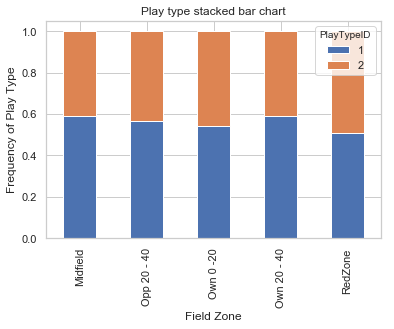

In [47]:
table=pd.crosstab(df.FieldZone, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type stacked bar chart')
plt.xlabel('Field Zone')
plt.ylabel('Frequency of Play Type')
plt.savefig('fieldzone_stacked')

### Down

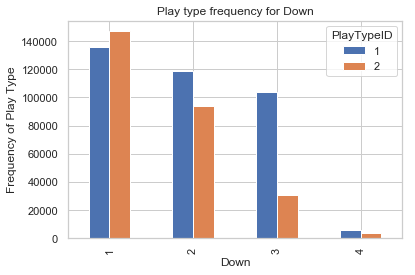

In [114]:
pd.crosstab(df.Down, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for Down')
plt.xlabel('Down')
plt.ylabel('Frequency of Play Type')
plt.savefig('Down_freq')

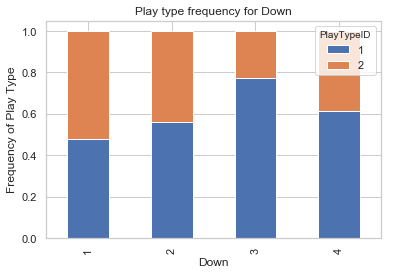

In [14]:
table=pd.crosstab(df.Down, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for Down')
plt.xlabel('Down')
plt.ylabel('Frequency of Play Type')
plt.savefig('Down_freq')

Down looks like a good predictor for play type, with the play type balance changing depending on the down.
4th down will always be smaller due to the fact most teams will punt on 4th down. May consider removing this from the dataset?

### Weather

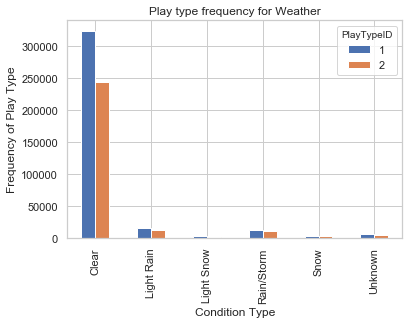

In [48]:
pd.crosstab(df.ConditionType, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for Weather')
plt.xlabel('Condition Type')
plt.ylabel('Frequency of Play Type')
plt.savefig('conditiontype_freq')

In [50]:
df[df['ConditionType'] == 'Clear']['PlayTypeID'].count()

568505

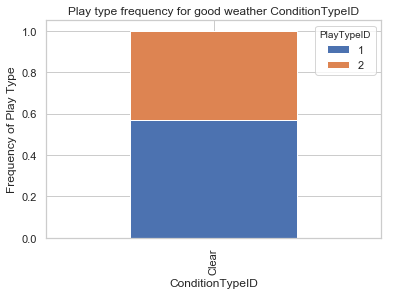

In [51]:
good_weather_df = df[df['ConditionType'] == 'Clear']
table=pd.crosstab(good_weather_df.ConditionType, good_weather_df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for good weather ConditionTypeID')
plt.xlabel('ConditionTypeID')
plt.ylabel('Frequency of Play Type')
plt.savefig('ConditionTypeID_good_freq')

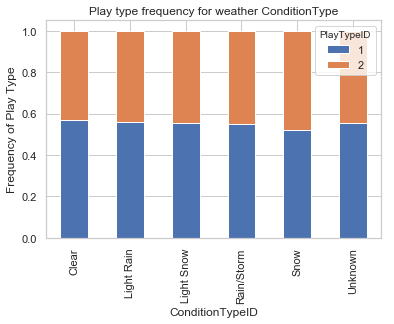

In [55]:
table=pd.crosstab(df.ConditionType, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for weather ConditionType')
plt.xlabel('ConditionTypeID')
plt.ylabel('Frequency of Play Type')
plt.savefig('ConditionTypeID_freq')

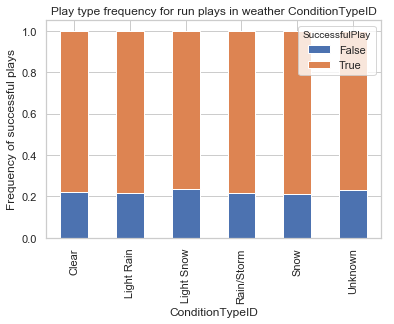

In [53]:
run_weather_df = df[df['PlayTypeID'] == 2]
table=pd.crosstab(run_weather_df.ConditionType, run_weather_df.SuccessfulPlay)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for run plays in weather ConditionTypeID')
plt.xlabel('ConditionTypeID')
plt.ylabel('Frequency of successful plays')
plt.savefig('ConditionTypeID_run_success_freq')

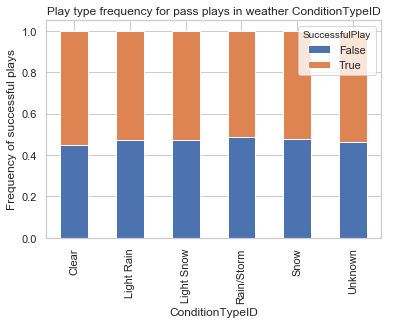

In [54]:
pass_weather_df = df[df['PlayTypeID'] == 1]
table=pd.crosstab(pass_weather_df.ConditionType, pass_weather_df.SuccessfulPlay)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for pass plays in weather ConditionTypeID')
plt.xlabel('ConditionTypeID')
plt.ylabel('Frequency of successful plays')
plt.savefig('ConditionTypeID_pass_success_freq')

Weather Condition Type is heavily swayed to Clear condition type.

### Wind Speed

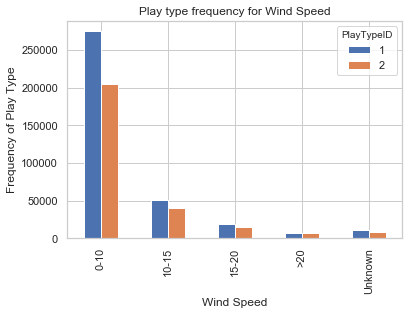

In [56]:
pd.crosstab(df.WindSpeedCategory, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency of Play Type')
plt.savefig('windspeed_freq')

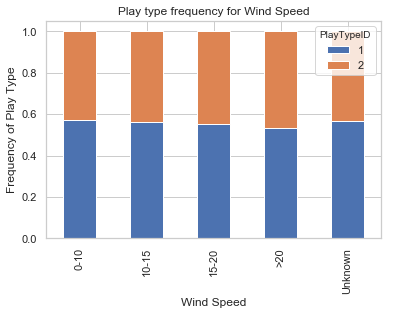

In [57]:
table=pd.crosstab(df.WindSpeedCategory, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency of Play Type')
plt.savefig('windspeedStacked_freq')

### Seconds Left In ....

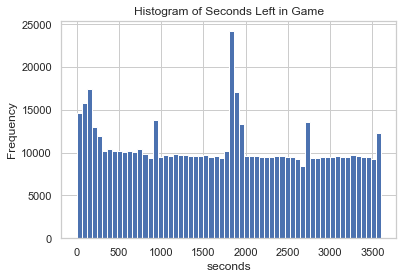

In [115]:
# Seconds Left in Game
df.SecondsLeftInGame.hist(bins=60)
plt.title('Histogram of Seconds Left in Game')
plt.xlabel('seconds')
plt.ylabel('Frequency')
plt.savefig('hist_slig')

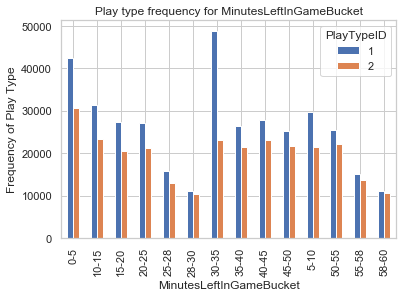

In [46]:
pd.crosstab(df.SecondsInGameBucket, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for MinutesLeftInGameBucket')
plt.xlabel('MinutesLeftInGameBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInGameBucket_freq')

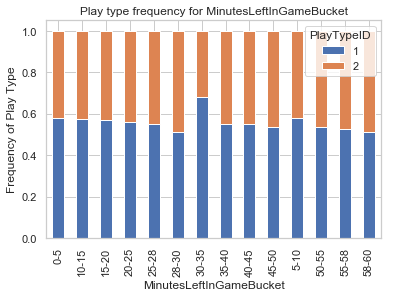

In [45]:
table=pd.crosstab(df.SecondsInGameBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for MinutesLeftInGameBucket')
plt.xlabel('MinutesLeftInGameBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInGameBucketStacked_freq')

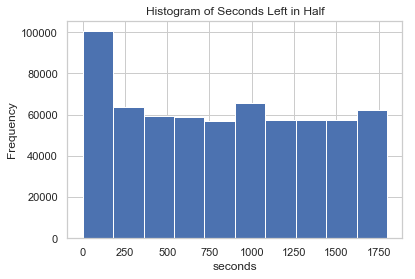

In [56]:
# Seconds Left in Half
df.SecondsLeftInHalf.hist(bins=10)
plt.title('Histogram of Seconds Left in Half')
plt.xlabel('seconds')
plt.ylabel('Frequency')
plt.savefig('hist_slih')

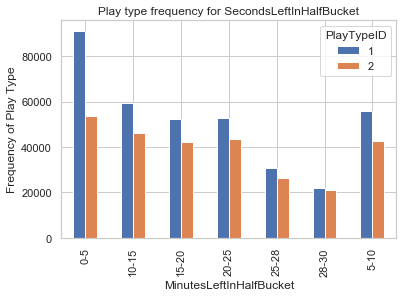

In [40]:
pd.crosstab(df.SecondsInHalfBucket, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for SecondsLeftInHalfBucket')
plt.xlabel('MinutesLeftInHalfBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInHalfBucket_freq')

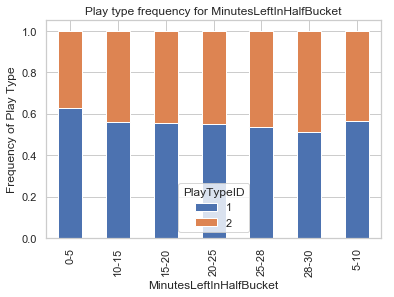

In [44]:
table=pd.crosstab(df.SecondsInHalfBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for MinutesLeftInHalfBucket')
plt.xlabel('MinutesLeftInHalfBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInHalfBucketStacked_freq')

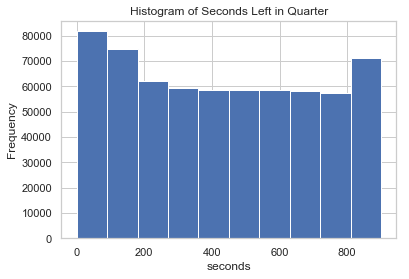

In [58]:
# Seconds Left in Quarter
df.SecondsLeftInQuarter.hist(bins=10)
plt.title('Histogram of Seconds Left in Quarter')
plt.xlabel('seconds')
plt.ylabel('Frequency')
plt.savefig('hist_sliq')

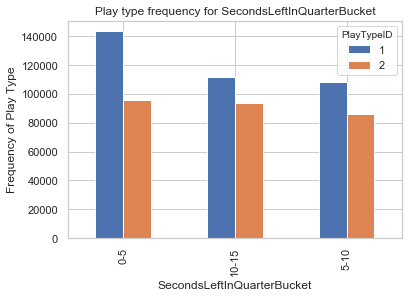

In [33]:
pd.crosstab(df.SecondsInQuarterBucket, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for SecondsLeftInQuarterBucket')
plt.xlabel('SecondsLeftInQuarterBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInQuarterBucket_freq')

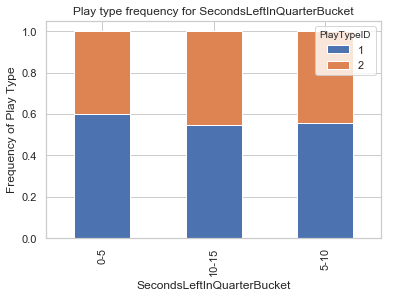

In [34]:
table=pd.crosstab(df.SecondsInQuarterBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for SecondsLeftInQuarterBucket')
plt.xlabel('SecondsLeftInQuarterBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInQuarterBucketStacked_freq')

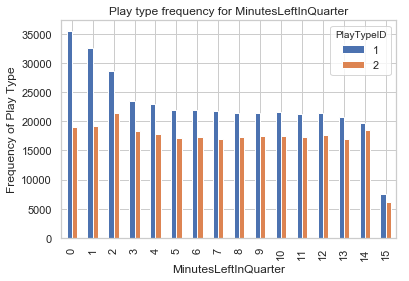

In [29]:
pd.crosstab(df.MinutesLeftInQuarter, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for MinutesLeftInQuarter')
plt.xlabel('MinutesLeftInQuarter')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInQuarter_freq')

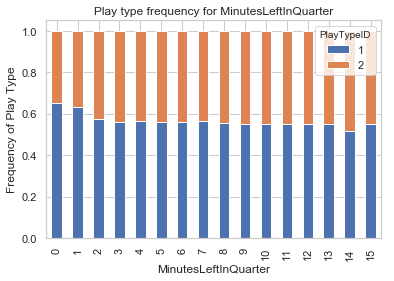

In [30]:
table=pd.crosstab(df.MinutesLeftInQuarter, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for MinutesLeftInQuarter')
plt.xlabel('MinutesLeftInQuarter')
plt.ylabel('Frequency of Play Type')
plt.savefig('MinutesLeftInQuarter_freq')

### TeamID

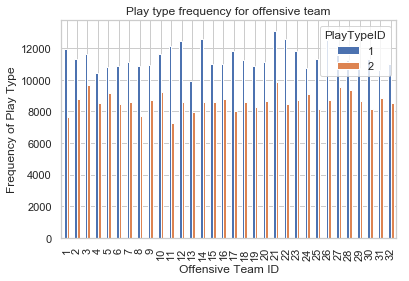

In [65]:
pd.crosstab(df.offenseID, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for offensive team')
plt.xlabel('Offensive Team ID')
plt.ylabel('Frequency of Play Type')
plt.savefig('offense_freq')

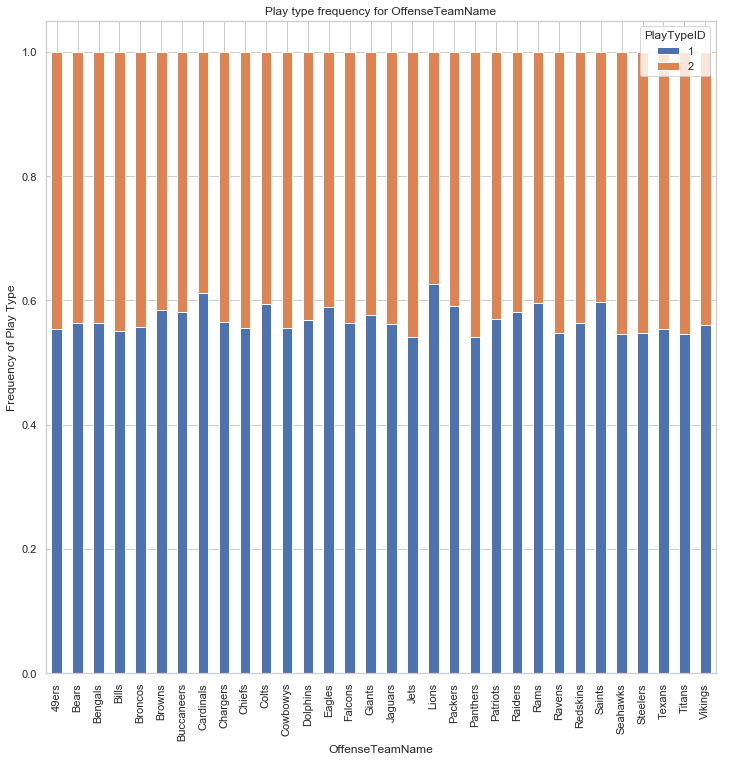

In [149]:
table=pd.crosstab(df.OffenseTeamName, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(12,12))
plt.title('Play type frequency for OffenseTeamName')
plt.xlabel('OffenseTeamName')
plt.ylabel('Frequency of Play Type')
plt.savefig('OffenseTeamName_freq')

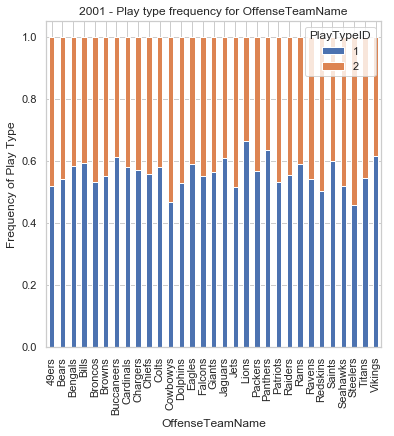

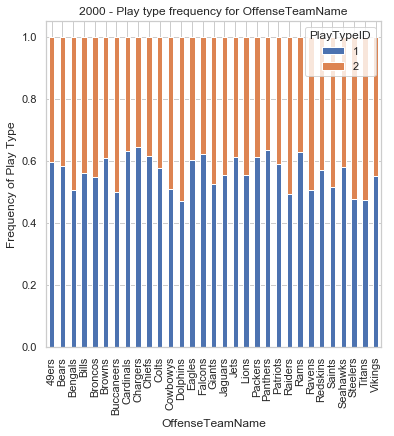

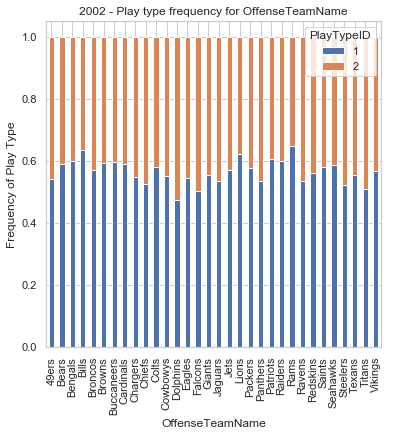

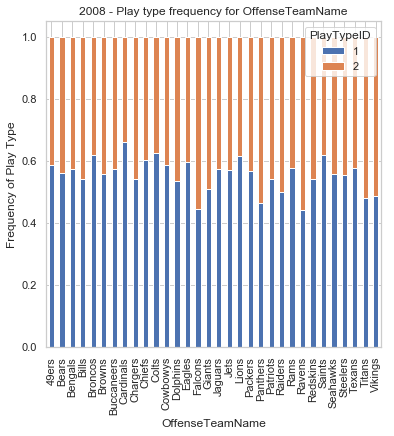

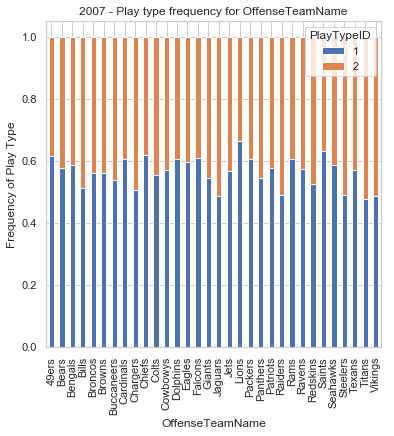

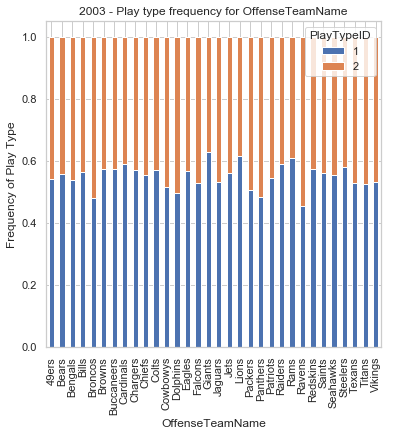

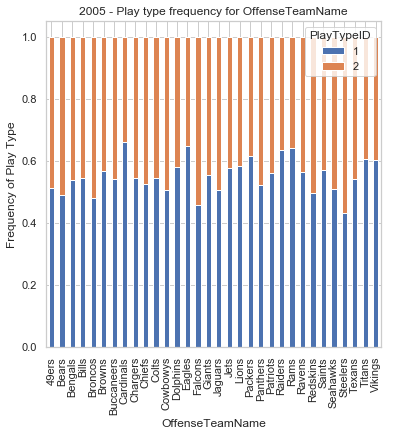

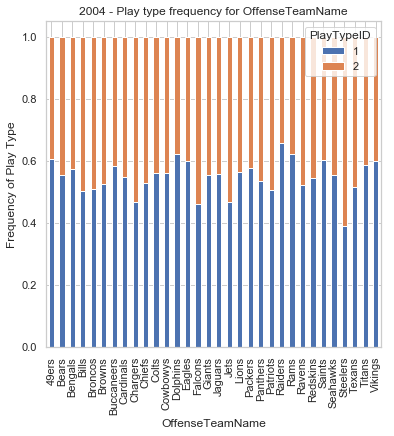

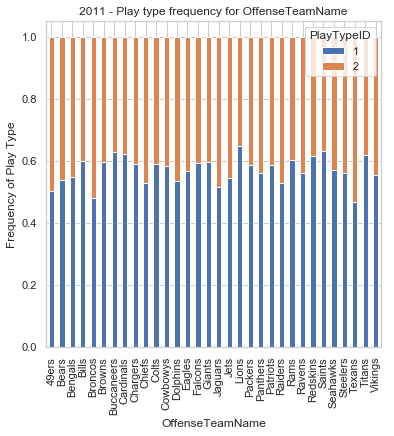

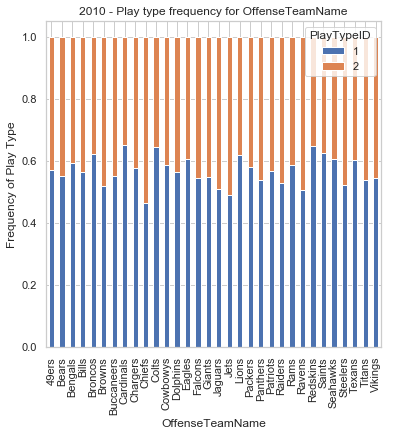

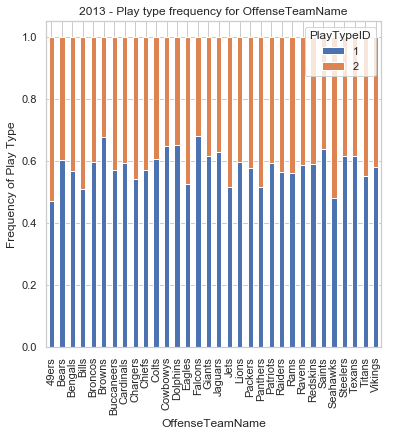

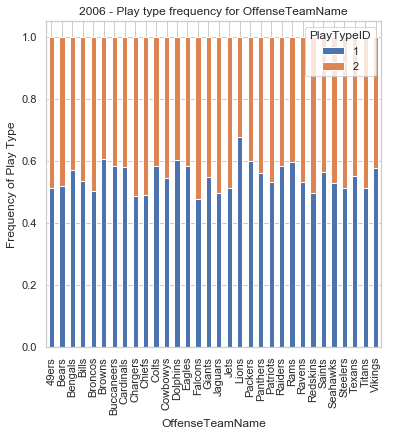

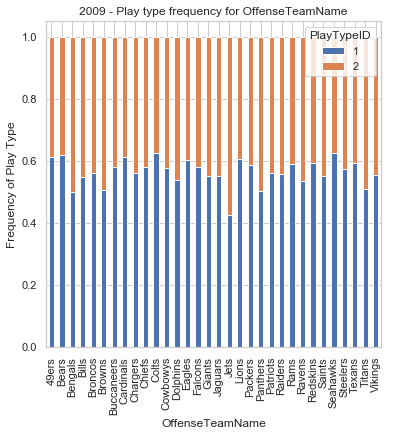

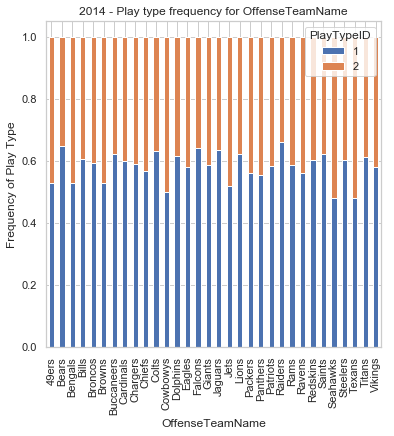

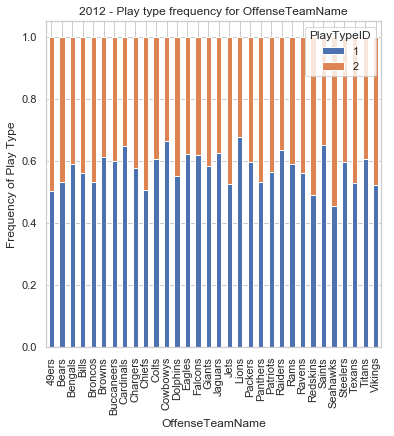

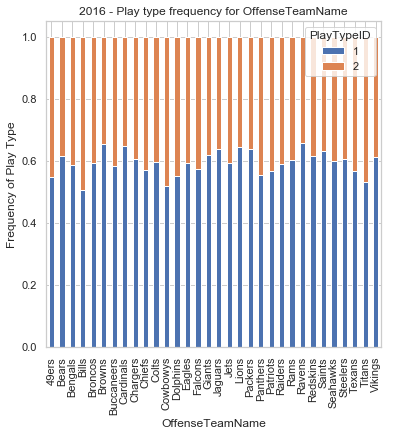

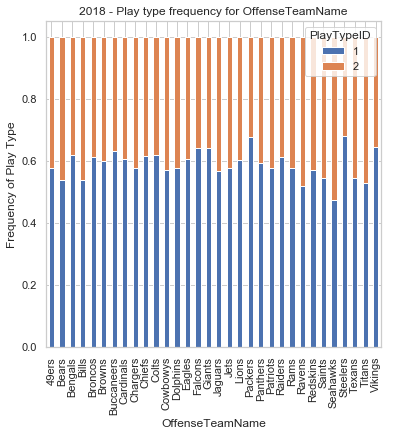

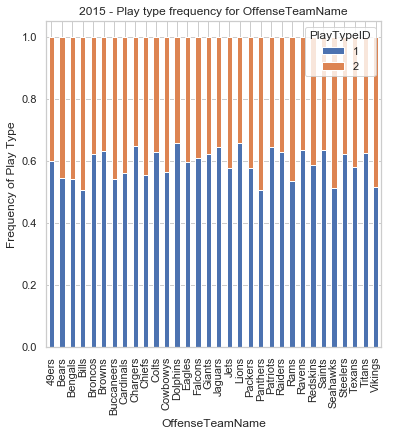

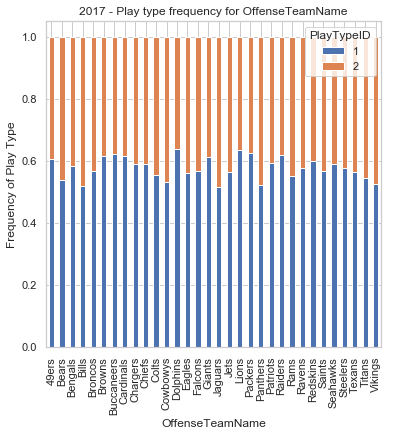

In [177]:
for y in df.GameYear.unique():
    table=pd.crosstab(df.loc[df['GameYear'] == y, 'OffenseTeamName'], df.loc[df['GameYear'] == y, 'PlayTypeID'])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(6,6))
    plt.title(f'{y} - Play type frequency for OffenseTeamName')
    plt.xlabel('OffenseTeamName')
    plt.ylabel('Frequency of Play Type')
    plt.savefig(f'OffenseTeamName{y}_freq')

plt.close()

Play type selection does change over the years per team, sometimes dramatically. However, using year as a predictor isn't useful. My potentially be useful to look at offsensive coordinator. However, would need to account for coordinators changing and new ones coming into the position

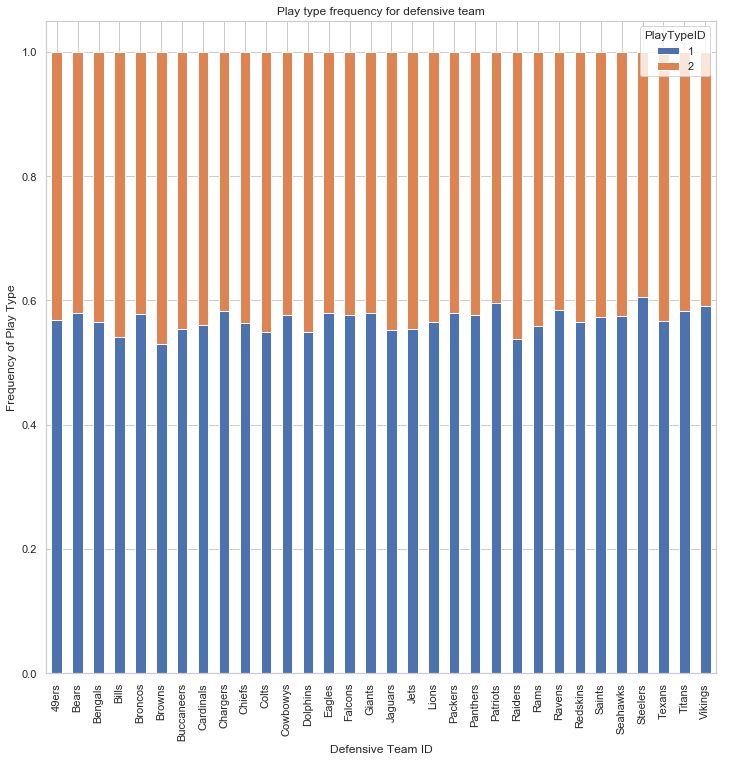

In [178]:
table=pd.crosstab(df.DefenseTeamName, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(12,12))
plt.title('Play type frequency for defensive team')
plt.xlabel('Defensive Team ID')
plt.ylabel('Frequency of Play Type')
plt.savefig('defense_freq')

### Surface

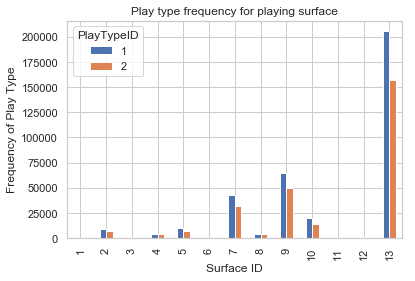

In [73]:
pd.crosstab(df.SurfaceID, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for playing surface')
plt.xlabel('Surface ID')
plt.ylabel('Frequency of Play Type')
plt.savefig('surface_freq')

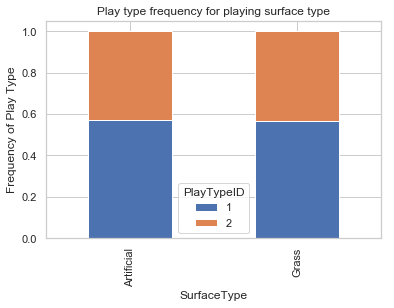

In [110]:
table=pd.crosstab(df.SurfaceType, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for playing surface type')
plt.xlabel('SurfaceType')
plt.ylabel('Frequency of Play Type')
plt.savefig('surfaceType_freq')

Text(0.5, 1.0, 'Artificial pitches over the years')

<Figure size 432x288 with 0 Axes>

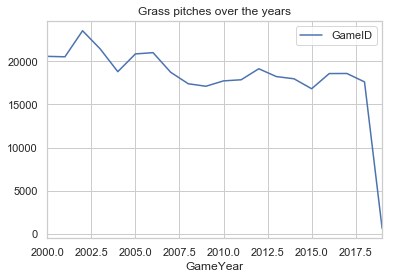

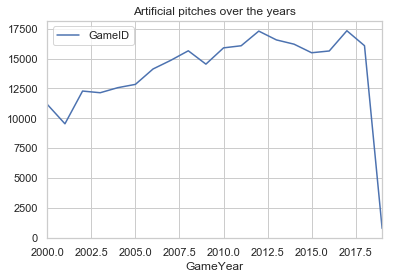

In [23]:
grass_df = df[df['SurfaceType'] == 'Grass'].groupby(['GameYear']).agg({'GameID' : 'count'})
art_df = df[df['SurfaceType'] == 'Artificial'].groupby(['GameYear']).agg({'GameID' : 'count'})
plt.figure()
grass_df.plot()
plt.title('Grass pitches over the years')
art_df.plot()
plt.title('Artificial pitches over the years')

The surface type doesn't seem to have any impact on the play type

### Yards To Go

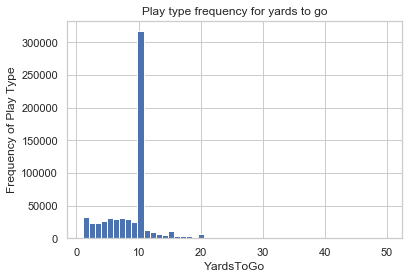

In [9]:
df.YardsToGo.hist(bins=50)
plt.title('Play type frequency for yards to go')
plt.xlabel('YardsToGo')
plt.ylabel('Frequency of Play Type')
plt.savefig('ytg_freq')

American Football starts each set of downs at 1st and 10, meaning the team is on it's first attempt to try to move 10 yards. This then will be the prodomenant yards to go. What happens if we filter it out?

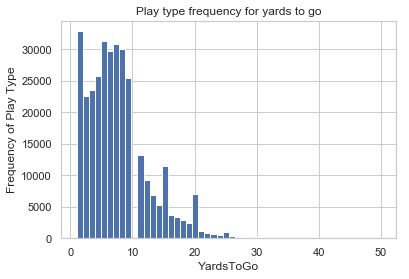

In [10]:
ytg_df = df[df.YardsToGo != 10]
ytg_df.YardsToGo.hist(bins=50)
# pd.crosstab(df.YardsToGo, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for yards to go')
plt.xlabel('YardsToGo')
plt.ylabel('Frequency of Play Type')
plt.savefig('ytg_no10_freq')

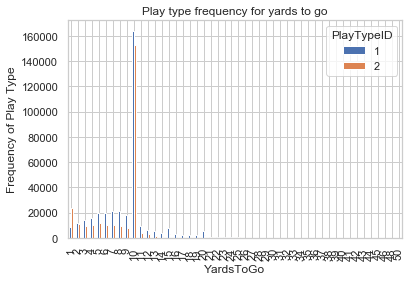

In [139]:
pd.crosstab(df.YardsToGo, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for yards to go')
plt.xlabel('YardsToGo')
plt.ylabel('Frequency of Play Type')
plt.savefig('ytg_freq')

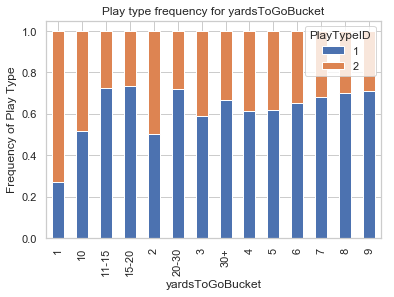

In [144]:
# pd.crosstab(df.yardsToGoBucket, df.PlayTypeID).plot(kind='bar')
table=pd.crosstab(df.yardsToGoBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for yardsToGoBucket')
plt.xlabel('yardsToGoBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('yardsToGoBucket_freq')

### Time outs left

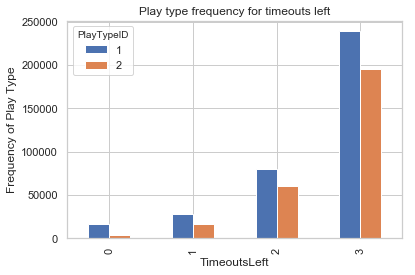

In [13]:
pd.crosstab(df.TimeoutsLeft, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for timeouts left')
plt.xlabel('TimeoutsLeft')
plt.ylabel('Frequency of Play Type')
plt.savefig('to_freq')

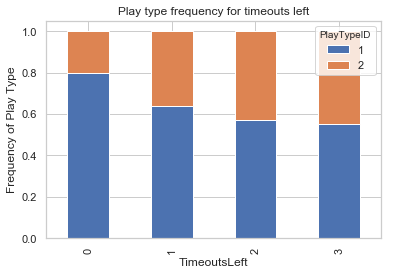

In [12]:
table=pd.crosstab(df.TimeoutsLeft, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for timeouts left')
plt.xlabel('TimeoutsLeft')
plt.ylabel('Frequency of Play Type')
plt.savefig('to_stacked_freq')

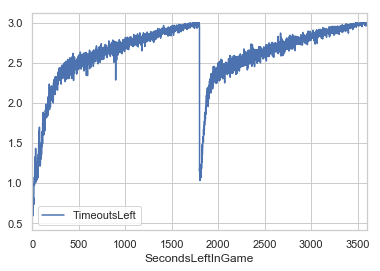

In [9]:
timeouts_df = df.groupby('SecondsLeftInGame').agg({'TimeoutsLeft' : 'mean'})
timeouts_df.plot()

### Game Quarter

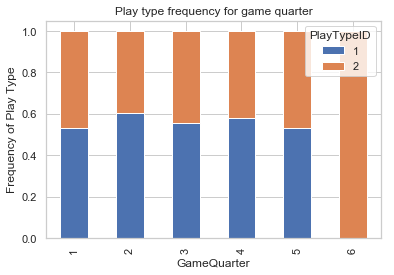

In [92]:
# pd.crosstab(df.GameQuarter, df.PlayTypeID).plot(kind='bar')
table=pd.crosstab(df.GameQuarter, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for game quarter')
plt.xlabel('GameQuarter')
plt.ylabel('Frequency of Play Type')
plt.savefig('quarter_freq')

### Current Points on Offense

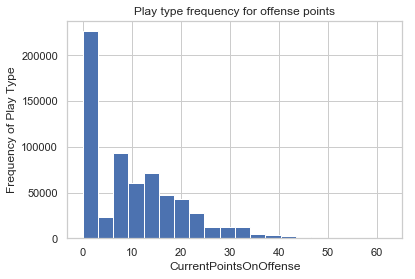

In [97]:
# pd.crosstab(df.CurrentPointsOnOffense, df.PlayTypeID).plot(kind='bar')
df.CurrentPointsOnOffense.hist(bins=20)
plt.title('Play type frequency for offense points')
plt.xlabel('CurrentPointsOnOffense')
plt.ylabel('Frequency of Play Type')
plt.savefig('offPoints_freq')

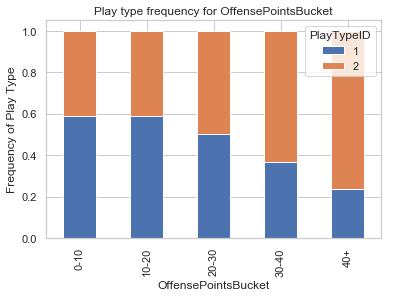

In [49]:
# pd.crosstab(df.OffensePointsBucket, df.PlayTypeID).plot(kind='bar')
table=pd.crosstab(df.OffensePointsBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for OffensePointsBucket')
plt.xlabel('OffensePointsBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('OffensePointsBucket_freq')

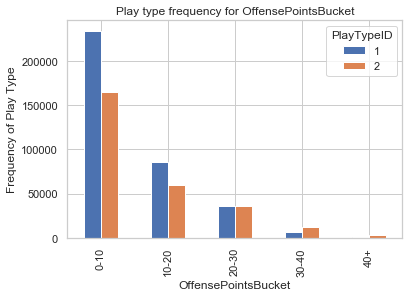

In [135]:
pd.crosstab(df.OffensePointsBucket, df.PlayTypeID).plot(kind='bar')
# df.CurrentPointsOnOffense.hist(bins=20)
plt.title('Play type frequency for OffensePointsBucket')
plt.xlabel('OffensePointsBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('OffensePointsBucket_freq')

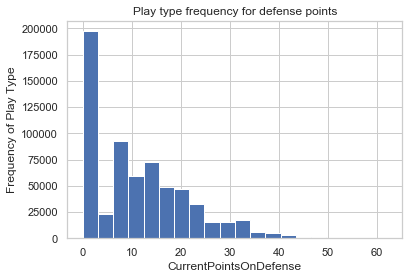

In [99]:
df.CurrentPointsOnDefense.hist(bins=20)
plt.title('Play type frequency for defense points')
plt.xlabel('CurrentPointsOnDefense')
plt.ylabel('Frequency of Play Type')
plt.savefig('DPoints_freq')

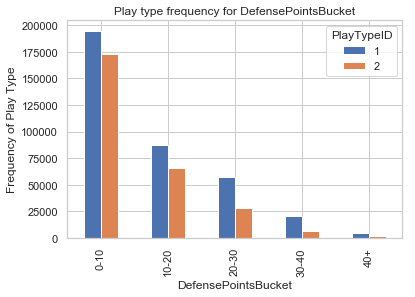

In [129]:
pd.crosstab(df.DefensePointsBucket, df.PlayTypeID).plot(kind='bar')
# df.CurrentPointsOnOffense.hist(bins=20)
plt.title('Play type frequency for DefensePointsBucket')
plt.xlabel('DefensePointsBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('DefensePointsBucket_freq')

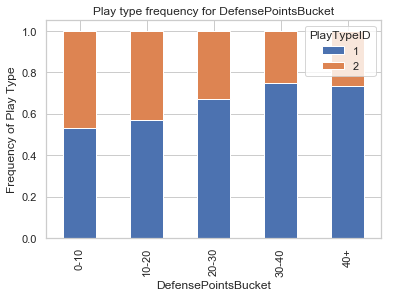

In [50]:
table=pd.crosstab(df.DefensePointsBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for DefensePointsBucket')
plt.xlabel('DefensePointsBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('DefensePointsBucket_freq')

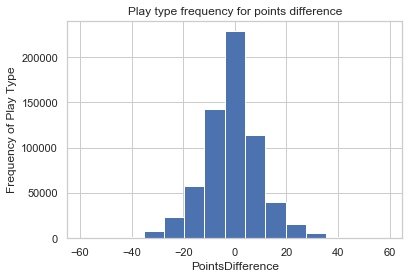

In [102]:
df.PointsDifference.hist(bins=15)
plt.title('Play type frequency for points difference')
plt.xlabel('PointsDifference')
plt.ylabel('Frequency of Play Type')
plt.savefig('pointsDiff_freq')

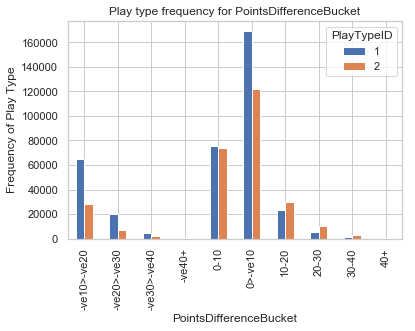

In [133]:
pd.crosstab(df.PointsDifferenceBucket, df.PlayTypeID).plot(kind='bar')
# df.CurrentPointsOnOffense.hist(bins=20)
plt.title('Play type frequency for PointsDifferenceBucket')
plt.xlabel('PointsDifferenceBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('PointsDifferenceBucket_freq')

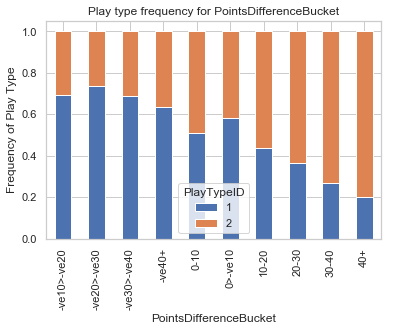

In [137]:
table=pd.crosstab(df.PointsDifferenceBucket, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for PointsDifferenceBucket')
plt.xlabel('PointsDifferenceBucket')
plt.ylabel('Frequency of Play Type')
plt.savefig('PointsDifferenceBucket_freq')

## Binary Features

### Shotgun

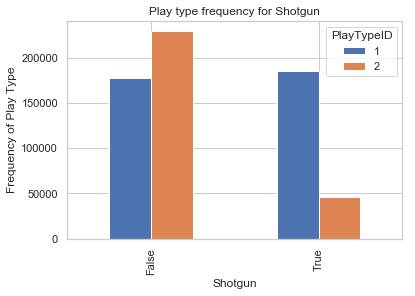

In [111]:
pd.crosstab(df.Shotgun, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for Shotgun')
plt.xlabel('Shotgun')
plt.ylabel('Frequency of Play Type')
plt.savefig('Shotgun_freq')

Shotgun could be a good factor to indicate play types
### QBisRookie

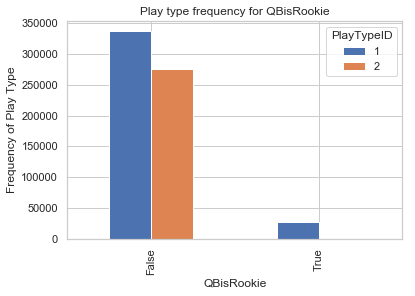

In [112]:
pd.crosstab(df.QBisRookie, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for QBisRookie')
plt.xlabel('QBisRookie')
plt.ylabel('Frequency of Play Type')
plt.savefig('QBisRookie_freq')

In [113]:
pd.crosstab(df.QBisRookie, df.PlayTypeID)

PlayTypeID,1,2
QBisRookie,,
False,336742,275842
True,27330,0


### Offensive win loss ratio

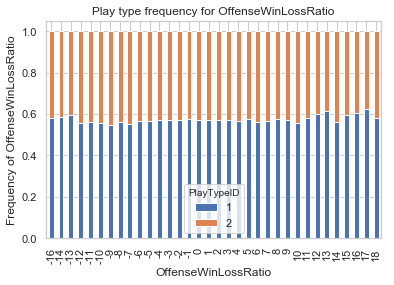

In [6]:
table=pd.crosstab(df.OffenseWinLossRatio, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for OffenseWinLossRatio')
plt.xlabel('OffenseWinLossRatio')
plt.ylabel('Frequency of OffenseWinLossRatio')
plt.savefig('OffenseWinLossRatio_freq')

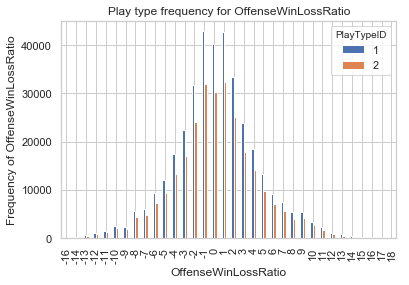

In [7]:
pd.crosstab(df.OffenseWinLossRatio, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for OffenseWinLossRatio')
plt.xlabel('OffenseWinLossRatio')
plt.ylabel('Frequency of OffenseWinLossRatio')
plt.savefig('OffenseWinLossRatio_freq')

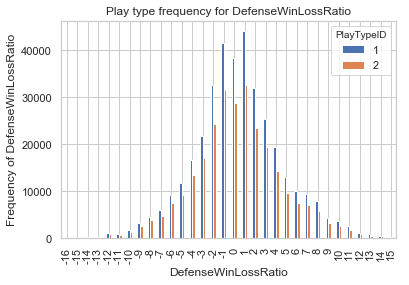

In [5]:
pd.crosstab(df.DefenseWinLossRatio, df.PlayTypeID).plot(kind='bar')
plt.title('Play type frequency for DefenseWinLossRatio')
plt.xlabel('DefenseWinLossRatio')
plt.ylabel('Frequency of DefenseWinLossRatio')
plt.savefig('DefenseWinLossRatio_freq')

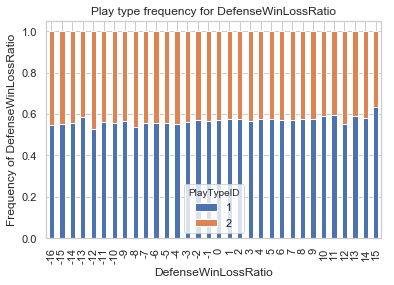

In [8]:
table=pd.crosstab(df.DefenseWinLossRatio, df.PlayTypeID)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Play type frequency for DefenseWinLossRatio')
plt.xlabel('DefenseWinLossRatio')
plt.ylabel('Frequency of DefenseWinLossRatio')
plt.savefig('DefenseWinLossRatio_freq')

## Correlation Plot
Check which features correlate to each other and thus may produce good predictions

C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\tj610\Anaconda3\envs\Uni\lib\site-packages\pandas\plotting\_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


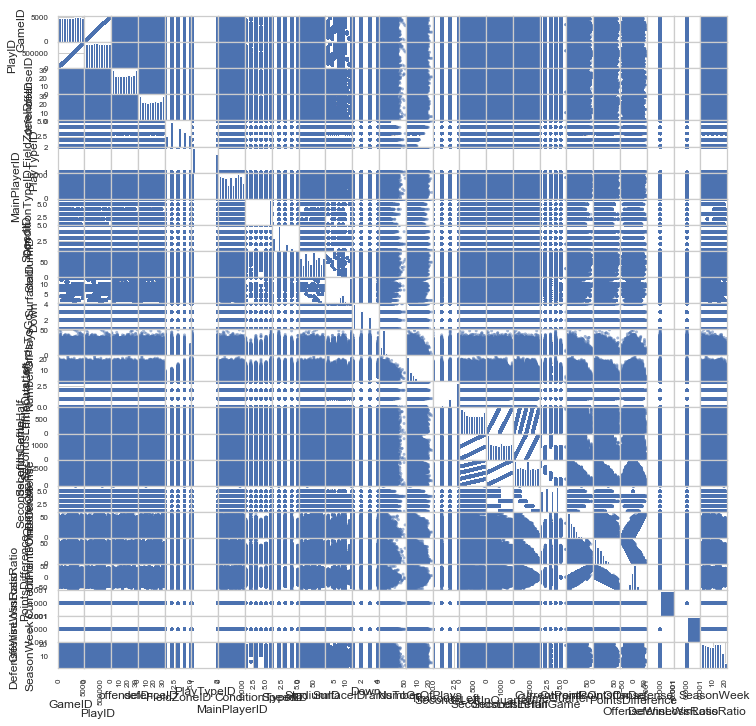

In [71]:
from pandas.plotting import scatter_matrix
scatter_df = df.drop(['SuccessfulPlay','Shotgun','AtHome','QBisRookie'], axis=1)
scatter_matrix(scatter_df, figsize=(12,12))
plt.show()